In [8]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal

import math
import matplotlib.pyplot as plt

import pypianoroll
import numpy as np
from pypianoroll import Multitrack, Track

In [9]:
# run params
run_id = '3001'
music_name = 'gan/'

RUN_FOLDER = 'run/'
RUN_FOLDER += '_'.join([run_id, music_name])

# Number of timestept the slices Pianorolls should have (Needs to be dividable by 16)
pianrollLength = 128

store_folder = os.path.join(RUN_FOLDER, 'store')
data_folder = os.path.join('../data', music_name)

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'store'))
    os.mkdir(os.path.join(RUN_FOLDER, 'output'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))

mode = 'build' # 'load' # 

#weight_init = RandomNormal(mean=0., stddev=0.02)
weight_init = tf.keras.initializers.GlorotUniform(seed=None)
#weight_init = tf.keras.initializers.he_uniform(seed=None)

In [10]:
# Set Note bounds for faster training
lowestNotePossible = 20
highestNotePossible = 108
# possibleNotes mus be dividable by 4 else the Architekture needs to be changed
possibleNotes = highestNotePossible - lowestNotePossible

In [4]:
# Save the numpyArray for further us
'''
reshaped = np.load('data/preprocessed/midi_p128_dn88.npy')
isNormalized = False

reshaped = np.load('data/preprocessed/midi_normalized_p128_dn88.npy')
isNormalized = True
'''

reshaped = np.load('data/preprocessed/midi_binarized_p128_dn88.npy')
isNormalized = True

"\nreshaped = np.load(os.path.join(RUN_FOLDER, 'store/reshaped_midi_binarized_p128_dn88.npy'))\nisNormalized = True\n"

# Creating the neural Network

In [5]:
### THE discriminator
discriminator_input = Input(shape=(pianrollLength,possibleNotes,1), name='discriminator_input')

x = discriminator_input


x = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding = 'same', kernel_initializer = weight_init, name = 'discriminator_conv_0')(x)
x = LeakyReLU()(x)
#x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding = 'same', kernel_initializer = weight_init, name = 'discriminator_conv_1')(x)
x = LeakyReLU()(x)
#x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(filters = 128, kernel_size = (1,5), strides=2, padding = 'same', kernel_initializer = weight_init, name = 'discriminator_conv_2')(x)
x = LeakyReLU()(x)
#x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(filters = 128, kernel_size = (5,5), strides=1, padding = 'same', kernel_initializer = weight_init, name = 'discriminator_conv_3')(x)
x = LeakyReLU()(x)
#x = Activation('relu')(x)
x = Dropout(0.1)(x)


x = Flatten()(x)

discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = weight_init)(x)
discriminator = Model(discriminator_input, discriminator_output, name= 'discriminator')

In [6]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 128, 88, 1)]      0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 64, 44, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 44, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 44, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 32, 22, 64)        102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 22, 64)      

In [7]:
# Quelle: https://stackoverflow.com/a/45199301
# Save the summary to a file 
#from contextlib import redirect_stdout

#with open(os.path.join(store_folder, 'modelsummarydiscriminator.txt'), 'w') as f:
#    with redirect_stdout(f):
#        discriminator.summary()

In [11]:
z_dim = 100

generator_input = Input(shape=(z_dim,), name='generator_input')
generator_initial_dense_layer_size = (int(pianrollLength/4),int(possibleNotes/4),8)

x = generator_input
x = Dense(np.prod(generator_initial_dense_layer_size), kernel_initializer = weight_init)(x)
x = BatchNormalization(momentum=0.9)(x)

#x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
x = Reshape(generator_initial_dense_layer_size)(x)

x = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
x = Conv2D(filters = 128, kernel_size = (5,5), padding='same', kernel_initializer = weight_init, name = 'generator_conv_0')(x)
x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
x = Conv2D(filters = 64, kernel_size = (5,5), padding='same', kernel_initializer = weight_init, name = 'generator_conv_1')(x)
x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(filters = 64, kernel_size = (5,5), padding = 'same', kernel_initializer = weight_init, name = 'generator_conv_2')(x)
x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(filters = 1, kernel_size = (5,5), padding = 'same', kernel_initializer = weight_init)(x)        
x = Activation('sigmoid')(x)


generator_output = x
generator = Model(generator_input, generator_output, name='generator')

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 5632)              568832    
_________________________________________________________________
batch_normalization (BatchNo (None, 5632)              22528     
_________________________________________________________________
activation (Activation)      (None, 5632)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5632)              0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 22, 8)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 44, 8)         0 

In [14]:
# Quelle: https://stackoverflow.com/a/45199301
# Save the summary to a file 
#from contextlib import redirect_stdout

#with open(os.path.join(store_folder, 'modelsummarygenerator.txt'), 'w') as f:
    #with redirect_stdout(f):
        #generator.summary()

In [11]:
def set_trainable(model, isTrainable):
    for layer in model.layers:
        layer.trainable = isTrainable

In [12]:
### COMPILE DISCRIMINATOR
discriminator.compile(
optimizer=RMSprop(lr=0.0008)
, loss = 'binary_crossentropy'
,  metrics = ['accuracy']
)
        
### COMPILE THE FULL GAN
set_trainable(discriminator, False)

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))
GANModel = Model(model_input, model_output)

opti = RMSprop(learning_rate=0.0004)
GANModel.compile(optimizer=opti , loss='binary_crossentropy', metrics=['accuracy'])

set_trainable(discriminator, True)


In [13]:
#plot_model(model, to_file=os.path.join(RUN_FOLDER ,'viz/model.png'), show_shapes = True, show_layer_names = True)
#plot_model(discriminator, to_file=os.path.join(RUN_FOLDER ,'viz/discriminator.png'), show_shapes = True, show_layer_names = True)
#plot_model(generator, to_file=os.path.join(RUN_FOLDER ,'viz/generator.png'), show_shapes = True, show_layer_names = True)

# Training of the GAN

In [14]:
def generate_Midi_File(img, epoch, isNormalized):
    gen_img = img.reshape(128, 88)
    result = np.zeros((pianrollLength, 128))
    result[:,lowestNotePossible:highestNotePossible] = gen_img
    #if isNormalized:
    #result = (result > 0.1) * 255.
    result = result * 255.
    
    track = Track(pianoroll=result, program=0, is_drum=False,name='my awesome piano')

    multi = Multitrack()
    multi.tracks[0] = track
    pypianoroll.write(multi, os.path.join(RUN_FOLDER, "images/"+str(epoch)+".mid"))
    
    multi.tracks[0].plot()
    #fig.set_size_inches(100,100)
    #plt.show()
    plt.savefig(os.path.join(RUN_FOLDER, "images/"+str(epoch)+"_pianoroll.png"), format='png')
    plt.close()

In [15]:
def train_normal(epochs, batch_size=128):
    # Save the Generator and discriminator models
    #save_model(generator, os.path.join(RUN_FOLDER, 'images/generator'))
    #save_model(discriminator, os.path.join(RUN_FOLDER, 'images/discriminator'))
    #save_model(GANModel, os.path.join(RUN_FOLDER, r"images/GANModel"))
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    # Label Smoothening
    valid_smoothened = np.random.uniform(low=0.8, high=1.0, size=(batch_size,1))
    fake_smoothened = np.random.uniform(low=0.0, high=0.05, size=(batch_size,1))
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------      
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)
        # Select a random half of images
        idx = np.random.randint(0, reshaped.shape[0], batch_size)
        imgs = reshaped[idx]
        
        # ---------------------
        #  Train the discriminator (real classified as ones and generated as zeros)
        # ---------------------
        d_loss_real, d_acc_real =  discriminator.train_on_batch(imgs, valid)
        d_loss_fake, d_acc_fake =  discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = GANModel.train_on_batch(noise, valid)
        #print ("%d [G loss: %.3f] [G acc: %.3f]" % (epoch, g_loss[0], g_loss[1]))
        
        # ---------------------
        #  Save Losses for evaluation
        # ---------------------
        d = [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]
        d_losses.append(d)
        g = [g_loss[0], g_loss[1]]
        g_losses.append(g)
        
        
        if (epoch % 100 == 0): 
            # Save an example
            fig=plt.figure(figsize=(64, 64))
            plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
            plt.axis('off')
            plt.savefig(os.path.join(RUN_FOLDER, "images/"+str(epoch)+".png"), format='png')
            generate_Midi_File(gen_imgs[0, :, :, 0], epoch, isNormalized)
            plt.close()
            
            # Continuiously save a plot with the new values to see the development of the loss
            fig = plt.figure()
            plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)
            plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
            plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
            plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

            plt.xlabel('batch', fontsize=18)
            plt.ylabel('loss', fontsize=16)

            # plt.xlim(0, 2000)
            #plt.ylim(0, 50)

            plt.savefig(os.path.join(RUN_FOLDER, "images/loss_chart.png"), format='png')
            plt.show()
            plt.close
            # Save the loss arrays
            np.save(os.path.join(RUN_FOLDER, "images/D_loss.npy"), d_losses)
            np.save(os.path.join(RUN_FOLDER, "images/G_loss.npy"), g_losses)
            
            if (epoch % 1000 == 0):
                GANModel.save(os.path.join(RUN_FOLDER, 'images/GANModel_'+str(epoch)+'_loss_'+str(g_loss[0])+'.h5'))
                discriminator.save(os.path.join(RUN_FOLDER, 'images/discriminator_'+str(epoch)+'_loss_'+str(d_loss)+'.h5'))
                generator.save(os.path.join(RUN_FOLDER, 'images/generator_'+str(epoch)+'_loss_'+str(g_loss[0])+'.h5'))
                
                
        # Plot the progress
        if (epoch % 10 == 0):
            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake, g_loss[0], g_loss[1]))

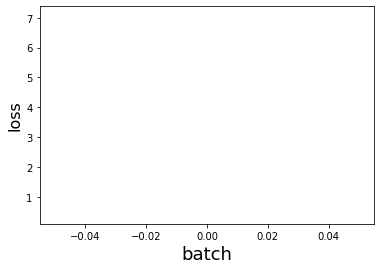

0 [D loss: (3.835)(R 0.620, F 7.050)] [D acc: (0.312)(0.625, 0.000)] [G loss: 0.423] [G acc: 1.000]
10 [D loss: (0.303)(R 0.001, F 0.606)] [D acc: (1.000)(1.000, 1.000)] [G loss: 0.850] [G acc: 0.000]
20 [D loss: (0.033)(R 0.002, F 0.064)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.111] [G acc: 0.000]
30 [D loss: (0.003)(R 0.000, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.741] [G acc: 0.000]
40 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.124] [G acc: 0.000]
50 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 9.098] [G acc: 0.000]
60 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 10.932] [G acc: 0.000]
70 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 10.703] [G acc: 0.000]
80 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 12.510] [G acc: 0.000]
90 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 13.929] [G

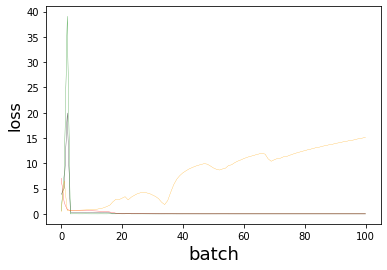

100 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 15.115] [G acc: 0.000]
110 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 16.156] [G acc: 0.000]
120 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 17.008] [G acc: 0.000]
130 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 18.146] [G acc: 0.000]
140 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 19.151] [G acc: 0.000]
150 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 19.936] [G acc: 0.000]
160 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 20.579] [G acc: 0.000]
170 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 21.100] [G acc: 0.000]
180 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 21.080] [G acc: 0.000]
190 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G

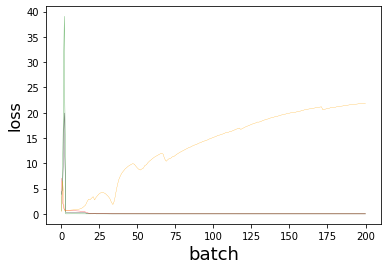

200 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 21.849] [G acc: 0.000]
210 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 22.121] [G acc: 0.000]
220 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 22.294] [G acc: 0.000]
230 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 22.426] [G acc: 0.000]
240 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 21.914] [G acc: 0.000]
250 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 18.184] [G acc: 0.000]
260 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 15.073] [G acc: 0.000]
270 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 14.672] [G acc: 0.000]
280 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 13.669] [G acc: 0.000]
290 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G

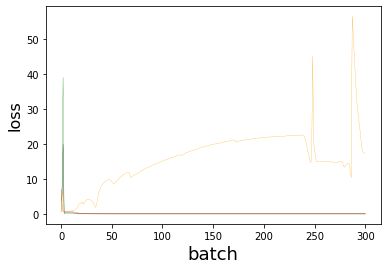

300 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 17.247] [G acc: 0.000]
310 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 17.861] [G acc: 0.000]
320 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 19.128] [G acc: 0.000]
330 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 19.967] [G acc: 0.000]
340 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 20.819] [G acc: 0.000]
350 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 53.827] [G acc: 0.000]
360 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.460] [G acc: 0.000]
370 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.366] [G acc: 0.000]
380 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.411] [G acc: 0.000]
390 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G

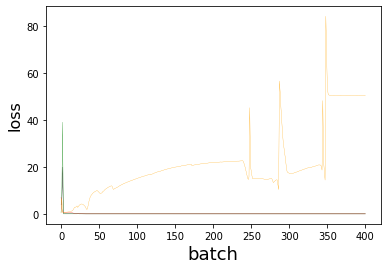

400 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.391] [G acc: 0.000]
410 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.355] [G acc: 0.000]
420 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.287] [G acc: 0.000]
430 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.378] [G acc: 0.000]
440 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.288] [G acc: 0.000]
450 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.301] [G acc: 0.000]
460 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.332] [G acc: 0.000]
470 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.294] [G acc: 0.000]
480 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.282] [G acc: 0.000]
490 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G

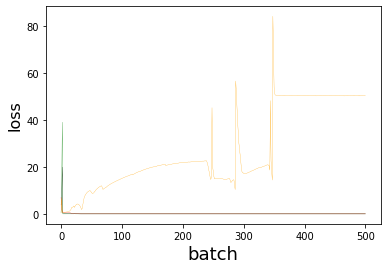

500 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.322] [G acc: 0.000]
510 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.377] [G acc: 0.000]
520 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.387] [G acc: 0.000]
530 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.265] [G acc: 0.000]
540 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.339] [G acc: 0.000]
550 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.226] [G acc: 0.000]
560 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.439] [G acc: 0.000]
570 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.273] [G acc: 0.000]
580 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 50.316] [G acc: 0.000]
590 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G

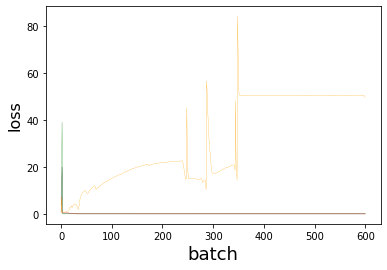

600 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.710] [G acc: 0.000]
610 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.636] [G acc: 0.000]
620 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.685] [G acc: 0.000]
630 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.728] [G acc: 0.000]
640 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.708] [G acc: 0.000]
650 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.704] [G acc: 0.000]
660 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.640] [G acc: 0.000]
670 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.617] [G acc: 0.000]
680 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 49.664] [G acc: 0.000]
690 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G

In [ ]:
d_losses = []
g_losses = []

train_normal(10001, batch_size=32)

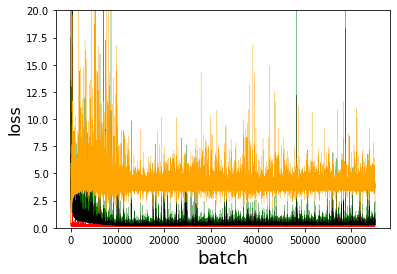

<function matplotlib.pyplot.close(fig=None)>

In [7]:
fig = plt.figure()
plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

#plt.xlim(0, 10000)
plt.ylim(0, 20)

plt.savefig(os.path.join(RUN_FOLDER, "images/loss_chart4.png"), format='png')
plt.show()
plt.close

In [ ]:
# Quelle: https://stackoverflow.com/a/6537563
# Beep to tell training finished
import winsound
frequency = 300  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [5]:
d_losses = np.load(os.path.join(RUN_FOLDER, "D_loss.npy"))
g_losses = np.load(os.path.join(RUN_FOLDER, "G_loss.npy"))

In [ ]:
#generator = load_model(os.path.join(RUN_FOLDER, "images/First_run/generator_10000_loss_30.628813.h5"))
#discriminator = load_model(os.path.join(RUN_FOLDER, "images/First_run/discriminator_10000_loss_5.734544512425027e-14.h5"))
#GANModel = load_model(os.path.join(RUN_FOLDER, "images/First_run/GANModel_10000_loss_30.628813.h5"))


In [ ]:
#generator.summary()